In [1]:
"""
This notebook reads water vapor data from GEOSCCM and GEOSCCM trajectory models.
We get the zonal mean water vapor seasonal cycle and June-July-August (JJA) water vapor.
We also get the seasonal cycles and amplitudes averaged in three latitude bands: 10-40N, 10S-10N, 10-40S.
Then we plot the data.
"""

'\nThis notebook reads water vapor data from GEOSCCM and GEOSCCM trajectory models.\nWe get the zonal mean water vapor seasonal cycle and June-July-August (JJA) water vapor.\nWe also get the seasonal cycles and amplitudes averaged in three latitude bands: 10-40N, 10S-10N, 10-40S.\nThen we plot the data.\n'

In [1]:
import numpy as np
import pandas as pd
import xarray as xr 
from seasonal_cycle_analysis_functions import *
import matplotlib.pyplot as plt
%matplotlib inline
degree_sign= u'\N{DEGREE SIGN}'
from string import ascii_lowercase
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Read and process data

In [2]:
indir = '/mnt/data/ice2/xwang/ACP2019_data_code/data/'
#--- specify file names to read
fname = ['MLS_h2omix.nc',\
         'geosccm_h2omix.nc',\
         'geosccm_TrajStandard_h2omix.nc',\
         'geosccm_TrajIce_h2omix.nc',\
         'geosccm_Traj02Ice_h2omix.nc',\
         'geosccm_TrajIceBelow90hPa_h2omix.nc']

#--- define arrays to store data
nfile = 6
nmonth = 12
nlat = 45
nlon = 45
nlatband = 3

h2o_mix = np.zeros((nfile,nmonth,nlat)) # stores zonal mean h2o seasonal cycle
h2o_mix2 = np.zeros((nfile,nlat,nlon))  # stores JJA mean h2o 
h2o_cycles = np.zeros((nfile,nlatband,nmonth)) # stores h2o seasonal cycle averaged in latitude bands
#--- begin reading data from file

for i,fn in zip(range(nfile),fname):
    #--- read water vapor data
    ff=xr.open_dataset(indir+fn)
    ff['time']=pd.to_datetime(ff.time, format='%Y%m')
    if fn == 'MLS_h2omix.nc':
        ff = ff.sel(pressure=100,method='nearest')
    h2o = ff.h2o_mix.sel(time=slice('2004-08-01','2018-10-31')).groupby('time.month').mean(dim='time')
    h2o_mix[i,:] = h2o.mean(dim='longitude').values
    h2o_mix2[i,:] = ff.h2o_mix.sel(time=slice('2004-08-01','2018-10-31')).groupby('time.season').mean(dim='time').sel(season='JJA').values
    
    h2o_cycles[i,0,:] = gavg(h2o.sel(latitude=slice(10,40))).values
    h2o_cycles[i,1,:] = gavg(h2o.sel(latitude=slice(-10,10))).values
    h2o_cycles[i,2,:] = gavg(h2o.sel(latitude=slice(-40,-10))).values
    if i == nfile-1:
        lat = ff.latitude.values
        lon = ff.longitude.values
    ff.close()

    
#--- get the seasonal amplitude of seaosnal cycles averaged in latitude bands
amp = seasonal_amp(h2o_cycles,-1)
#--- get the seasonal cycles with the annual mean subtracted
h2o_cycles_mean = np.nanmean(h2o_cycles,axis=-1)
h2o_cycles_sub=h2o_cycles-h2o_cycles_mean[:,:,np.newaxis]

/usr/local/anaconda/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Begin plotting Figures

In [3]:
#--- pre-define some variables to aid the plotting

#--- specify vmin, vmax, y/x ticks
vmax = 6
vmin = 2
levels = np.linspace(vmin,vmax,20)
xt = np.arange(1,13,1)
lattick = [-40,-20,0,20,40]
lontick = [0,120,240,360]

#--- titles, ylabels, xlabels, ticklabels, etc
titles = ['GEOSCCM','GEOSCCM standard trajectory','GEOSCCM ice model','GEOSCCM 0.2ice model','GEOSCCM ice model\n below 90 hpa',]
latstr = ['40'+degree_sign+' S','20'+degree_sign+' S','0','20'+degree_sign+' N','40'+degree_sign+' N']
lonstr = ['0'+degree_sign+' E','120'+degree_sign+' E','240'+degree_sign+' E','360'+degree_sign+' E']
prstr = ['100 hPa','82.5 hPa', '68 hPa']
xtk = np.array([calendar.month_abbr[i][0] for i in xt]) 

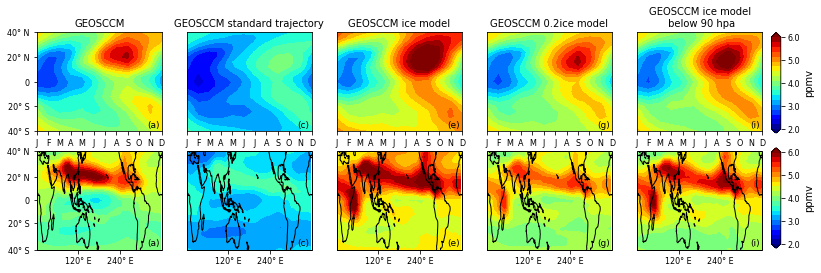

In [4]:
fig = plt.figure(figsize=[13,4])

llabel = ascii_lowercase[::2]
for j in range(nfile-1):    
    ax = plt.subplot(2,nfile-1,j+1)  
    ax.set_aspect('auto')  
    ima = ax.contourf(xt,lat,h2o_mix[j+1,:,:].T,cmap='jet',\
                      levels=levels,extend='both')           # plot water vapor seasonal cycle  
      
    ax.set_xticks(xt)                                        # set up ticks, labels, etc.
    ax.set_xticklabels(xtk,fontsize=8)
    if j ==0:
        ax.set_yticks(lattick)
        ax.set_yticklabels(latstr,fontsize=8)
    else:
        ax.set_yticks([])
    ax.set_ylim([-40,40])
    ax.annotate('('+llabel[j]+')',xy=(0.98,0.02),xycoords='axes fraction',\
                size=9,ha='right',va='bottom')           
    ax.set_title(titles[j],fontsize=10) 
cbaxes = fig.add_axes([0.91,0.53,0.01,0.35])                # setup colobar
colorbar_setting(fig,ima,ax,vmin,vmax,5,'ppmv',cbaxes)


proj = ccrs.Mercator(central_longitude=180)                 # begin plotting the JJA water vapor
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
for j in range(nfile-1):
    ax = plt.subplot(2,nfile-1,j+nfile,projection=proj)  
    ax.set_aspect('auto')  
    ima = ax.contourf(lon,lat,h2o_mix2[j+1,:],cmap='jet',levels=levels,\
                      extend='both',transform=ccrs.PlateCarree())  # plot JJA water vapor
    ax.coastlines()                                                # plot coastline, set up ticks, labels, etc.
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    if j == 0:
        ax.set_yticks(lattick,crs=ccrs.PlateCarree())
        ax.set_yticklabels(latstr,fontsize=8)
    ax.set_xticks(lontick,crs=ccrs.PlateCarree())
    ax.set_xticklabels(lonstr,fontsize=8)
    ax.set_extent([1,359,-40,40],crs=ccrs.PlateCarree())
    ax.annotate('('+llabel[j]+')',xy=(0.98,0.02),xycoords='axes fraction',\
                size=9,ha='right',va='bottom')   
cbaxes = fig.add_axes([0.91,0.13,0.01,0.35])    
colorbar_setting(fig,ima,ax,vmin,vmax,5,'ppmv',cbaxes)            # setup colobar



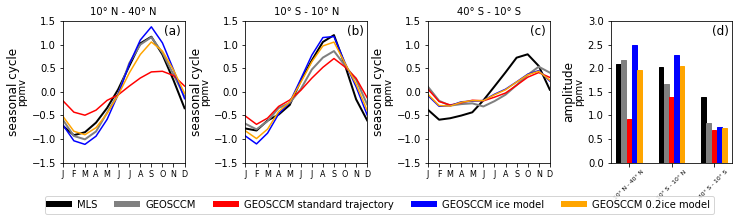

In [5]:
fig,ax = plt.subplots(nrows=1,ncols=4)
fig.set_size_inches(12,2.6,forward=True)

#--- pre-define some variables to aid the plotting
xbar = np.array([np.linspace(1,1.9,5),np.linspace(2.8,3.7,5),np.linspace(4.6,5.5,5)])
color = ['k','gray','r','b','orange']
lw = [2,2,1.5,1.5,1.5]
labels = ['MLS','GEOSCCM','GEOSCCM standard trajectory','GEOSCCM ice model','GEOSCCM 0.2ice model']
title = ['10'+degree_sign+' N - 40'+degree_sign+' N',\
         '10'+degree_sign+' S - 10'+degree_sign+' N',\
         '40'+degree_sign+' S - 10'+degree_sign+' S']
llabel = ascii_lowercase[:6]

#--- begin plotting the seasonal cycles in latitude bands
for i in range(nlatband):  
    for j in range(nfile-1):
        ax[i].plot(xt,h2o_cycles_sub[j,i,:],color=color[j],label=labels[j],lw=lw[j])
    ax[i].set_xlim([1,12])
    ax[i].set_xticks(xt)
    ax[i].set_xticklabels(xtk,fontsize=8)
    ax[i].set_title(title[i],fontsize=10)
    ax[i].set_ylim([-1.5,1.5])
    ax[i].annotate('('+llabel[i]+')',xy=(0.97,0.97),xycoords='axes fraction',size=12,ha='right',va='top')   
    ax[i].set_ylabel('ppmv')
    ax[i].annotate('seasonal cycle',xy=(-0.35,0.5),\
                          xycoords='axes fraction',size=12,ha='right',va='center',rotation=90)

#--- begin plotting the seasonal amplitudes   
for i in range(nlatband): 
    barlist = ax[-1].bar(xbar[i,:],amp[:-1,i],width=0.2) 
    for j in range(nfile-1):
        barlist[j].set_color(color[j])    
ax[-1].set_xticks([1.45,3.25,5.05])   
ax[-1].set_xticklabels(title,fontsize=6,rotation=45)
ax[-1].set_ylim([0,3])
for j in range(nfile-1):
    ax[-1].plot(1,0,lw=6,color=color[j],label=labels[j]) # helps set up the legend
ax[-1].set_ylabel('ppmv')
ax[-1].legend(bbox_to_anchor=(-1.9,-0.2,0.,0.),loc='upper center',ncol=5)
ax[-1].annotate('amplitude',xy=(-0.29,0.5),\
                          xycoords='axes fraction',size=12,ha='right',va='center',rotation=90)
ax[-1].annotate('(d)',xy=(0.97,0.97),xycoords='axes fraction',size=12,ha='right',va='top') 
plt.subplots_adjust(wspace=0.5)
